## Questions Answering: 

### Question 1: How did the spatial distribution of public transport recovery after COVID-19 relate to local economic resilience and demographic change?

Key Sub-questions:
Spatial Patterns:
Which suburbs/stations saw the fastest or slowest recovery in ridership?
Are there clusters of high/low recovery?
Economic Resilience:
Did areas with higher income, lower unemployment, or more diverse economies recover faster?
Did areas with more essential workers or less remote work recover differently?
Demographic Change:
Did age, household size, ethnicity, or migration patterns affect recovery?
Did population growth or decline during/after COVID-19 play a role?
COVID-19 Impact:
Did areas with more severe or longer lockdowns, or higher case rates, recover more slowly?
Was there a “lag” in recovery in certain regions?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
# =============================================
# CHUNK 1: DATA LOADING AND INITIAL EXPLORATION
# =============================================

# Load the data
df = pd.read_csv('AustraliaSpecificData/confirmed_cases_table1_location.csv')

print("=== BASIC DATA OVERVIEW ===")
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['notification_date'].min()} to {df['notification_date'].max()}")
print(f"Total confirmed cases: {len(df)}")
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())


=== BASIC DATA OVERVIEW ===
Dataset shape: (973412, 6)
Date range: 2020-01-25 to 2022-02-07
Total confirmed cases: 973412

First few rows:
  notification_date  postcode lhd_2010_code         lhd_2010_name lga_code19  \
0        2020-01-25    2134.0          X700                Sydney      11300   
1        2020-01-25    2121.0          X760       Northern Sydney      16260   
2        2020-01-25    2071.0          X760       Northern Sydney      14500   
3        2020-01-27    2033.0          X720  South Eastern Sydney      16550   
4        2020-03-01    2077.0          X760       Northern Sydney      14000   

        lga_name19  
0      Burwood (A)  
1   Parramatta (C)  
2  Ku-ring-gai (A)  
3     Randwick (C)  
4      Hornsby (A)  

Data types:
notification_date     object
postcode             float64
lhd_2010_code         object
lhd_2010_name         object
lga_code19            object
lga_name19            object
dtype: object

Missing values:
notification_date        0
postcode 

In [4]:
# =============================================
# CHUNK 2: DATA PREPROCESSING
# =============================================

# Convert date column to datetime
df['notification_date'] = pd.to_datetime(df['notification_date'])

# Extract additional time features
df['year'] = df['notification_date'].dt.year
df['month'] = df['notification_date'].dt.month
df['week'] = df['notification_date'].dt.isocalendar().week
df['day_of_week'] = df['notification_date'].dt.day_name()
df['quarter'] = df['notification_date'].dt.quarter

# Clean LGA names and extract council types
df['council_type'] = df['lga_name19'].str.extract(r'\(([AC])\)$')
df['lga_clean'] = df['lga_name19'].str.replace(r'\s*\([AC]\)$', '', regex=True)

print("=== DATA PREPROCESSING COMPLETE ===")
print(f"Council types found: {df['council_type'].value_counts()}")
print(f"Date range: {df['notification_date'].min().date()} to {df['notification_date'].max().date()}")


=== DATA PREPROCESSING COMPLETE ===
Council types found: council_type
A    480319
C    413439
Name: count, dtype: int64
Date range: 2020-01-25 to 2022-02-07


In [5]:
# =============================================
# CHUNK 3: TEMPORAL ANALYSIS
# =============================================

print("\n=== TEMPORAL ANALYSIS ===")

# Daily case counts
daily_cases = df.groupby('notification_date').size().reset_index(name='daily_cases')
daily_cases['7day_avg'] = daily_cases['daily_cases'].rolling(7, center=True).mean()

# Monthly aggregation
monthly_cases = df.groupby(['year', 'month']).size().reset_index(name='monthly_cases')
monthly_cases['date'] = pd.to_datetime(monthly_cases[['year', 'month']].assign(day=1))

# Weekly patterns
weekly_pattern = df.groupby('day_of_week').size().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

print("Top 10 days with highest cases:")
print(daily_cases.nlargest(10, 'daily_cases')[['notification_date', 'daily_cases']])

print(f"\nAverage daily cases: {daily_cases['daily_cases'].mean():.1f}")
print(f"Peak daily cases: {daily_cases['daily_cases'].max()}")
print(f"Peak date: {daily_cases.loc[daily_cases['daily_cases'].idxmax(), 'notification_date'].date()}")



=== TEMPORAL ANALYSIS ===
Top 10 days with highest cases:
    notification_date  daily_cases
653        2022-01-06        41338
652        2022-01-05        40162
654        2022-01-07        38148
657        2022-01-10        32493
659        2022-01-12        29908
651        2022-01-04        29425
658        2022-01-11        28928
655        2022-01-08        28543
661        2022-01-14        27074
650        2022-01-03        26768

Average daily cases: 1419.0
Peak daily cases: 41338
Peak date: 2022-01-06


In [6]:
# =============================================
# CHUNK 4: GEOGRAPHICAL ANALYSIS
# =============================================

print("\n=== GEOGRAPHICAL ANALYSIS ===")

# Cases by Local Health District
lhd_cases = df.groupby('lhd_2010_name').size().sort_values(ascending=False)
print("Cases by Local Health District:")
print(lhd_cases)

# Cases by LGA
lga_cases = df.groupby('lga_clean').size().sort_values(ascending=False)
print(f"\nTop 15 LGAs by case count:")
print(lga_cases.head(15))

# Cases by postcode
postcode_cases = df.groupby('postcode').size().sort_values(ascending=False)
print(f"\nTop 15 postcodes by case count:")
print(postcode_cases.head(15))

# Council type analysis
council_analysis = df.groupby('council_type').agg({
    'lga_clean': 'nunique',
    'postcode': 'count'
}).rename(columns={'lga_clean': 'num_councils', 'postcode': 'total_cases'})
if not council_analysis.empty:
    council_analysis['avg_cases_per_council'] = council_analysis['total_cases'] / council_analysis['num_councils']
    print(f"\nCouncil type analysis:")
    print(council_analysis)



=== GEOGRAPHICAL ANALYSIS ===
Cases by Local Health District:
lhd_2010_name
South Western Sydney     167966
Western Sydney           156064
South Eastern Sydney     130981
Sydney                    94283
Hunter New England        90354
Northern Sydney           90349
Nepean Blue Mountains     45136
Illawarra Shoalhaven      44768
Central Coast             35734
Northern NSW              27065
Murrumbidgee              21840
Western NSW               21459
Mid North Coast           17437
Southern NSW              12799
Correctional settings      1570
Far West                   1525
Hotel Quarantine             35
dtype: int64

Top 15 LGAs by case count:
lga_clean
Canterbury-Bankstown       68654
Blacktown                  61799
Cumberland                 48815
Liverpool                  41805
Central Coast (C) (NSW)    35734
Fairfield                  35702
Sydney                     34097
Northern Beaches           32075
Penrith                    32060
Sutherland Shire           2993

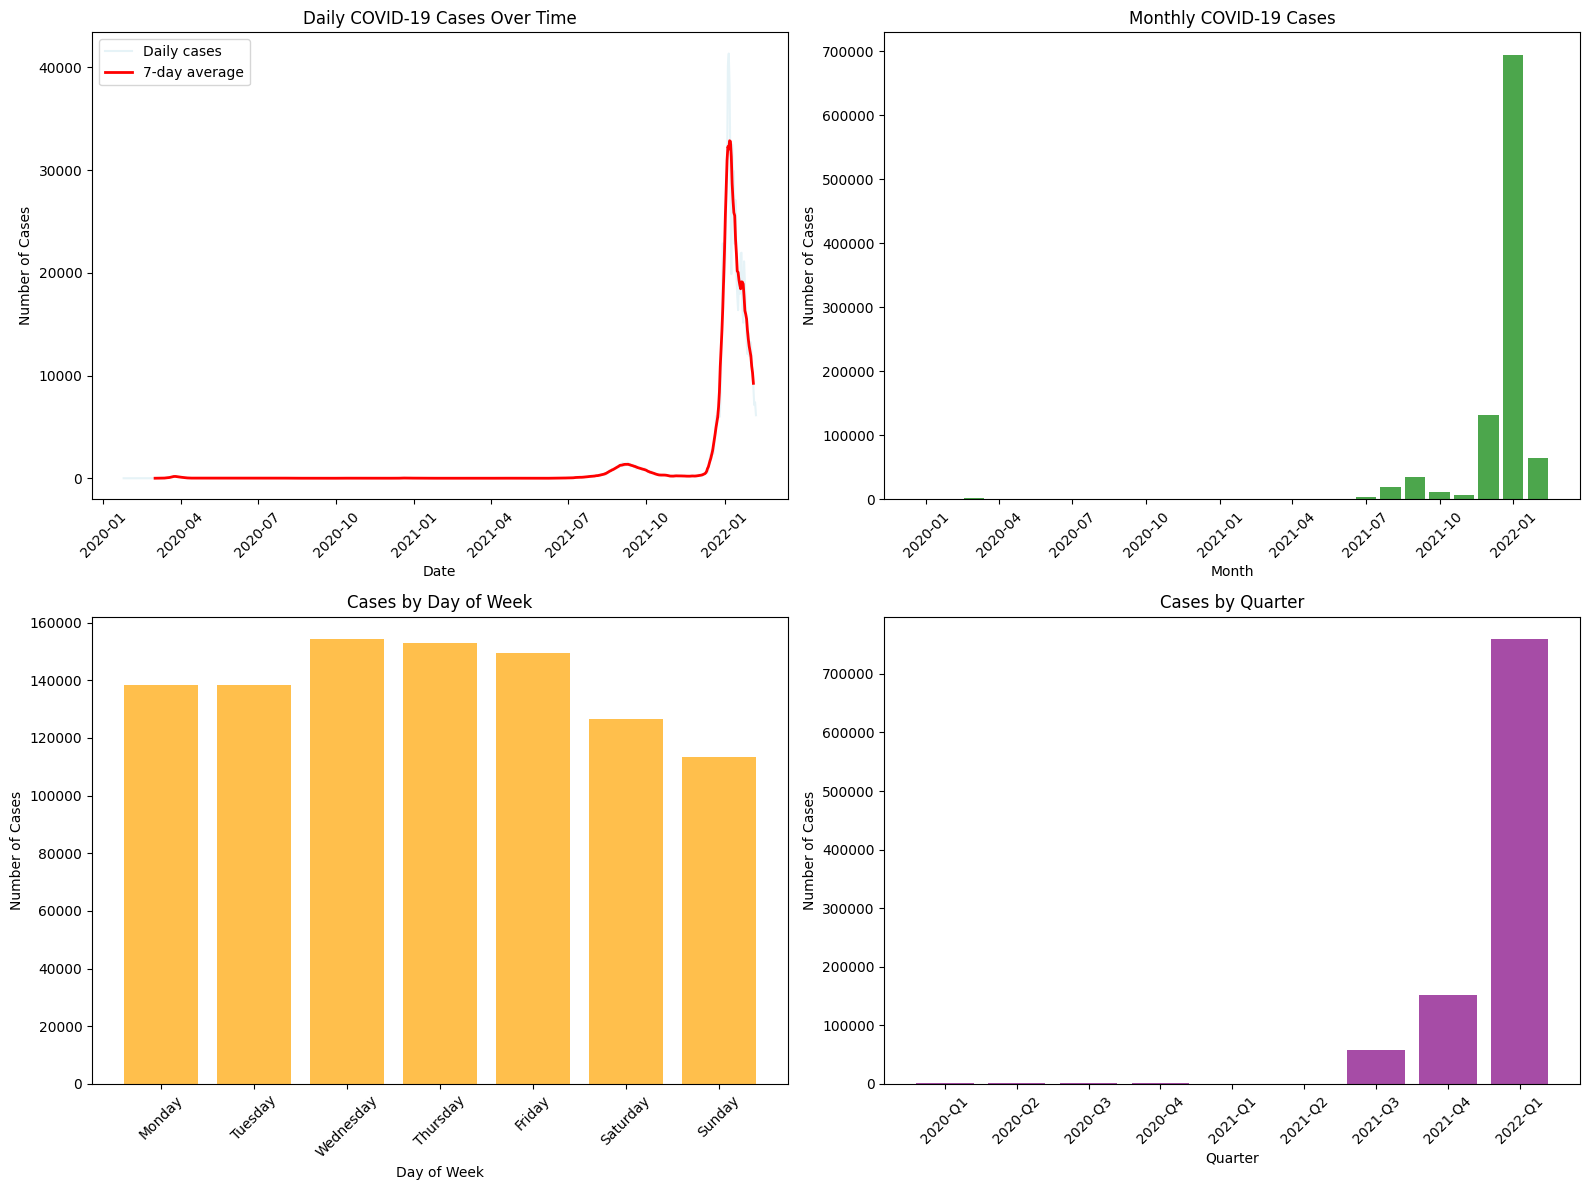

In [7]:
# =============================================
# CHUNK 5: VISUALIZATION - TIME SERIES
# =============================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Daily cases with rolling average
axes[0,0].plot(daily_cases['notification_date'], daily_cases['daily_cases'], 
               alpha=0.3, color='lightblue', label='Daily cases')
axes[0,0].plot(daily_cases['notification_date'], daily_cases['7day_avg'], 
               color='red', linewidth=2, label='7-day average')
axes[0,0].set_title('Daily COVID-19 Cases Over Time')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Number of Cases')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)

# Monthly cases
axes[0,1].bar(monthly_cases['date'], monthly_cases['monthly_cases'], 
              width=25, alpha=0.7, color='green')
axes[0,1].set_title('Monthly COVID-19 Cases')
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Number of Cases')
axes[0,1].tick_params(axis='x', rotation=45)

# Weekly pattern
axes[1,0].bar(weekly_pattern.index, weekly_pattern.values, color='orange', alpha=0.7)
axes[1,0].set_title('Cases by Day of Week')
axes[1,0].set_xlabel('Day of Week')
axes[1,0].set_ylabel('Number of Cases')
axes[1,0].tick_params(axis='x', rotation=45)

# Quarterly distribution
quarterly_cases = df.groupby(['year', 'quarter']).size().reset_index(name='cases')
quarterly_labels = [f"{row['year']}-Q{row['quarter']}" for _, row in quarterly_cases.iterrows()]
axes[1,1].bar(range(len(quarterly_cases)), quarterly_cases['cases'], 
              color='purple', alpha=0.7)
axes[1,1].set_title('Cases by Quarter')
axes[1,1].set_xlabel('Quarter')
axes[1,1].set_ylabel('Number of Cases')
axes[1,1].set_xticks(range(len(quarterly_cases)))
axes[1,1].set_xticklabels(quarterly_labels, rotation=45)

plt.tight_layout()
plt.show()



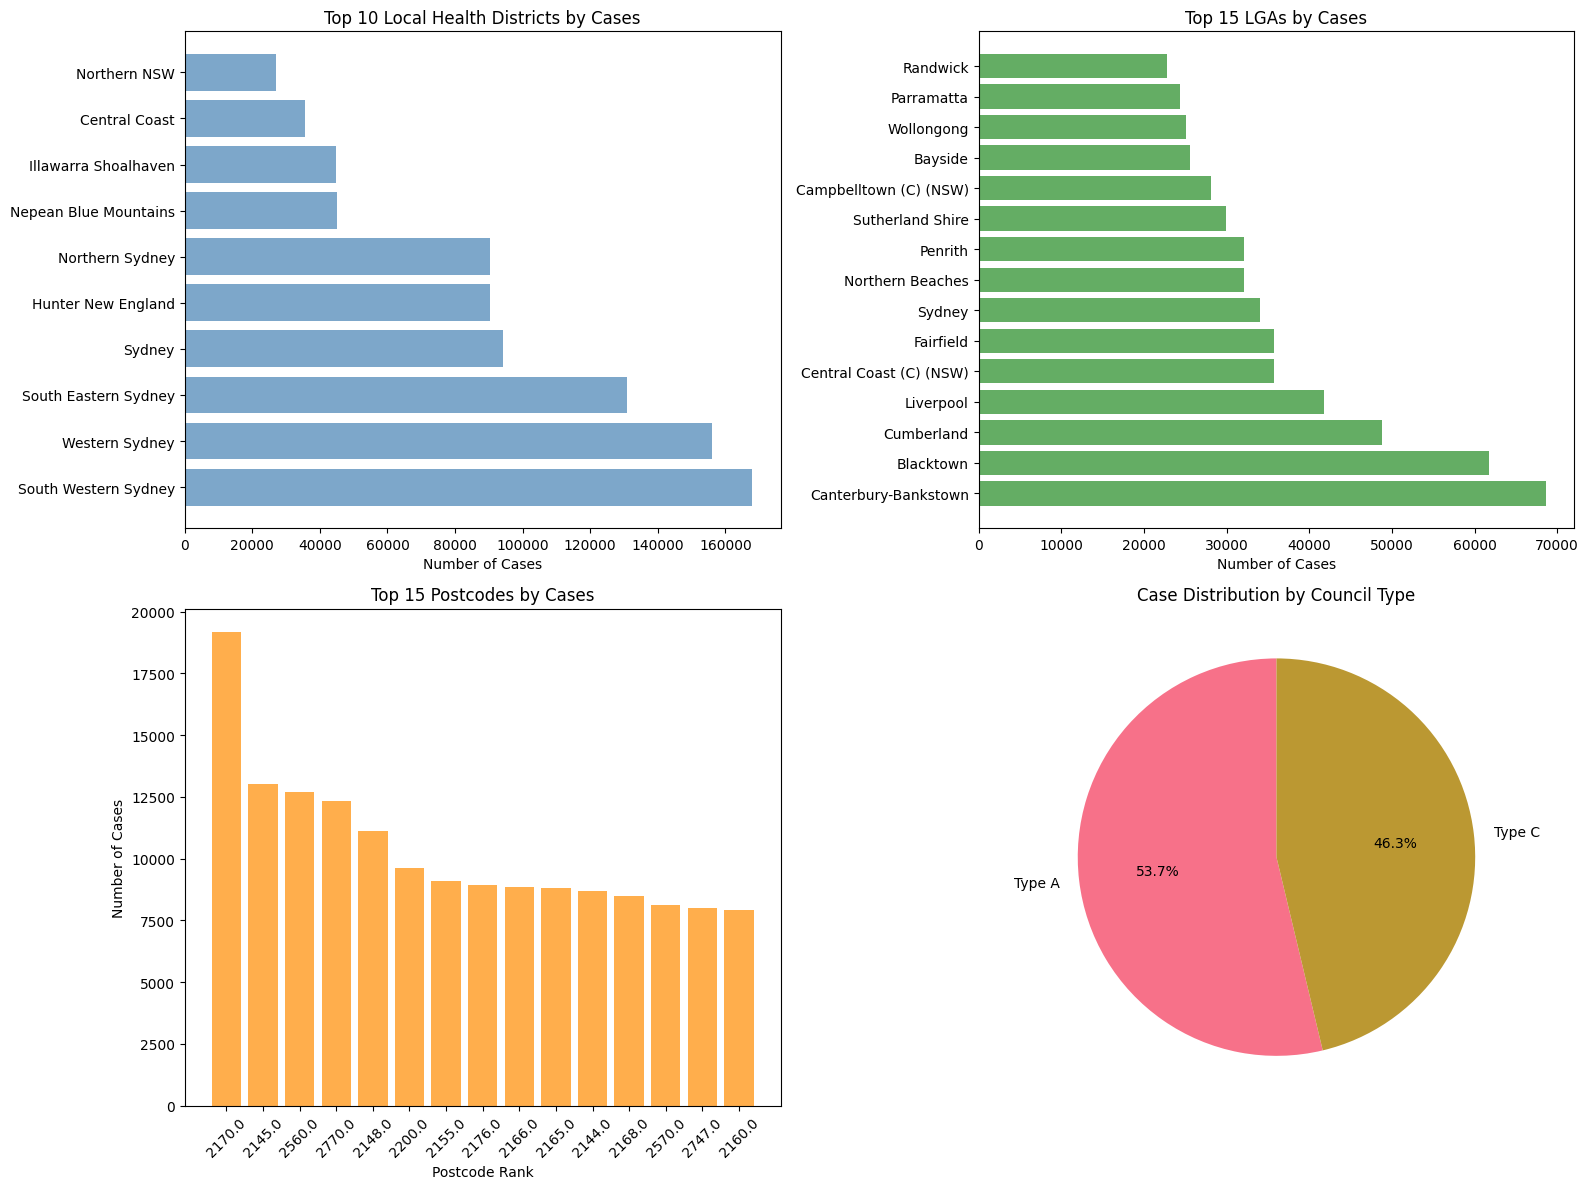

In [8]:
# =============================================
# CHUNK 6: VISUALIZATION - GEOGRAPHICAL
# =============================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top LHDs
top_lhds = lhd_cases.head(10)
axes[0,0].barh(range(len(top_lhds)), top_lhds.values, color='steelblue', alpha=0.7)
axes[0,0].set_yticks(range(len(top_lhds)))
axes[0,0].set_yticklabels(top_lhds.index)
axes[0,0].set_title('Top 10 Local Health Districts by Cases')
axes[0,0].set_xlabel('Number of Cases')

# Top LGAs
top_lgas = lga_cases.head(15)
axes[0,1].barh(range(len(top_lgas)), top_lgas.values, color='forestgreen', alpha=0.7)
axes[0,1].set_yticks(range(len(top_lgas)))
axes[0,1].set_yticklabels(top_lgas.index)
axes[0,1].set_title('Top 15 LGAs by Cases')
axes[0,1].set_xlabel('Number of Cases')

# Top postcodes
top_postcodes = postcode_cases.head(15)
axes[1,0].bar(range(len(top_postcodes)), top_postcodes.values, color='darkorange', alpha=0.7)
axes[1,0].set_title('Top 15 Postcodes by Cases')
axes[1,0].set_xlabel('Postcode Rank')
axes[1,0].set_ylabel('Number of Cases')
axes[1,0].set_xticks(range(len(top_postcodes)))
axes[1,0].set_xticklabels([str(x) for x in top_postcodes.index], rotation=45)

# Council type distribution (if data available)
if not council_analysis.empty:
    axes[1,1].pie(council_analysis['total_cases'], 
                  labels=[f"Type {idx}" for idx in council_analysis.index],
                  autopct='%1.1f%%', startangle=90)
    axes[1,1].set_title('Case Distribution by Council Type')
else:
    axes[1,1].text(0.5, 0.5, 'Council type data\nnot available', 
                   ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Council Type Distribution')

plt.tight_layout()
plt.show()



In [9]:
# =============================================
# CHUNK 7: ADVANCED ANALYSIS
# =============================================

print("\n=== ADVANCED ANALYSIS ===")

# Growth rate analysis
daily_cases_sorted = daily_cases.sort_values('notification_date')
daily_cases_sorted['growth_rate'] = daily_cases_sorted['daily_cases'].pct_change() * 100
daily_cases_sorted['cumulative_cases'] = daily_cases_sorted['daily_cases'].cumsum()

print("Growth rate statistics:")
print(f"Average daily growth rate: {daily_cases_sorted['growth_rate'].mean():.2f}%")
print(f"Max daily growth rate: {daily_cases_sorted['growth_rate'].max():.2f}%")
print(f"Min daily growth rate: {daily_cases_sorted['growth_rate'].min():.2f}%")

# Identify waves/peaks
from scipy.signal import find_peaks
peaks, properties = find_peaks(daily_cases_sorted['7day_avg'].dropna(), 
                              height=daily_cases_sorted['7day_avg'].quantile(0.8),
                              distance=14)  # At least 2 weeks apart

if len(peaks) > 0:
    print(f"\nIdentified {len(peaks)} major peaks:")
    peak_dates = daily_cases_sorted.iloc[peaks]['notification_date'].values
    peak_values = daily_cases_sorted.iloc[peaks]['7day_avg'].values
    for date, value in zip(peak_dates, peak_values):
        print(f"  {pd.to_datetime(date).date()}: {value:.0f} cases (7-day avg)")

# LGA diversity analysis
lga_stats = df.groupby('lga_clean').agg({
    'notification_date': ['min', 'max', 'count'],
    'postcode': 'nunique'
}).round(2)
lga_stats.columns = ['first_case', 'last_case', 'total_cases', 'postcodes_affected']
lga_stats['days_with_cases'] = (lga_stats['last_case'] - lga_stats['first_case']).dt.days + 1
lga_stats['avg_cases_per_day'] = lga_stats['total_cases'] / lga_stats['days_with_cases']

print(f"\nLGA with longest outbreak duration:")
longest_outbreak = lga_stats.loc[lga_stats['days_with_cases'].idxmax()]
print(f"  {longest_outbreak.name}: {longest_outbreak['days_with_cases']} days")

print(f"\nLGA with highest average daily cases:")
highest_avg = lga_stats.loc[lga_stats['avg_cases_per_day'].idxmax()]
print(f"  {highest_avg.name}: {highest_avg['avg_cases_per_day']:.2f} cases/day")




=== ADVANCED ANALYSIS ===
Growth rate statistics:
Average daily growth rate: 28.41%
Max daily growth rate: 900.00%
Min daily growth rate: -91.67%

Identified 4 major peaks:
  2021-09-03: 1298 cases (7-day avg)
  2021-10-19: 312 cases (7-day avg)
  2022-01-04: 30941 cases (7-day avg)
  2022-01-18: 19304 cases (7-day avg)

LGA with longest outbreak duration:
  Burwood: 745 days

LGA with highest average daily cases:
  Canterbury-Bankstown: 97.11 cases/day



=== SUMMARY STATISTICS ===
Summary by Local Health District:
                      first_case  last_case  total_cases  lgas_affected  \
lhd_2010_name                                                             
South Western Sydney  2020-03-01 2022-02-07       167966              8   
Western Sydney        2020-03-03 2022-02-07       156064              5   
South Eastern Sydney  2020-01-27 2022-02-07       130981              7   
Sydney                2020-01-25 2022-02-07        94283              6   
Hunter New England    2020-03-13 2022-02-07        90354             22   
Northern Sydney       2020-01-25 2022-02-07        90349             11   
Nepean Blue Mountains 2020-03-08 2022-02-07        45136              5   
Illawarra Shoalhaven  2020-03-15 2022-02-07        44768              4   
Central Coast         2020-03-11 2022-02-07        35734              1   
Northern NSW          2020-03-14 2022-02-07        27065              8   
Murrumbidgee          2020-03-22 2022-

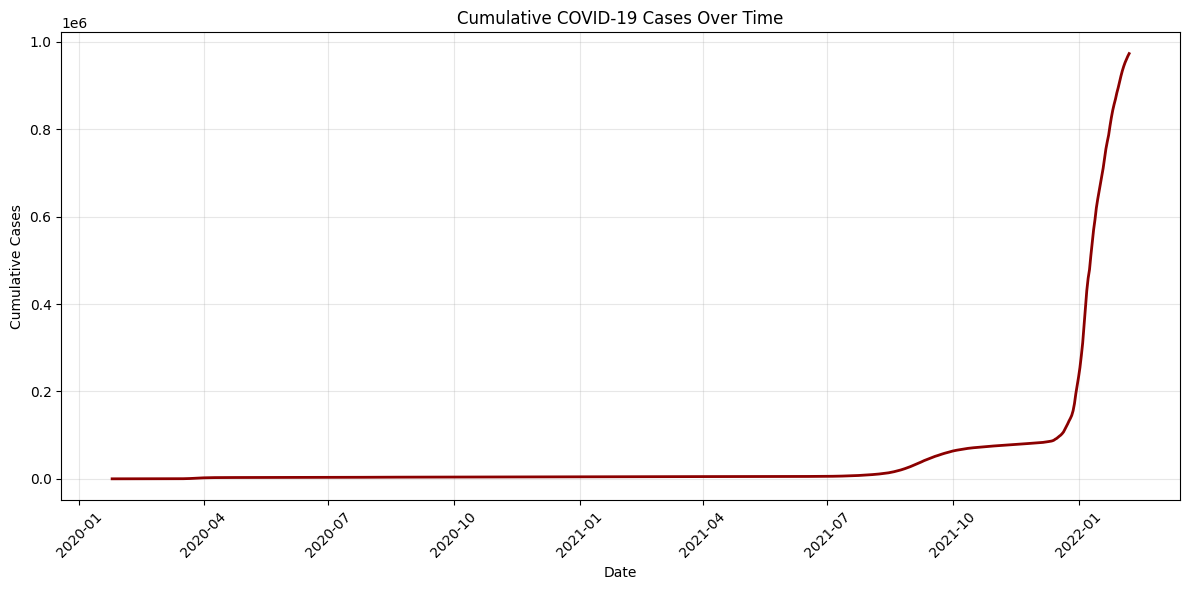


✅ Analysis complete! Total cumulative cases: 973,412


In [10]:
# =============================================
# CHUNK 8: CORRELATION AND SUMMARY STATISTICS
# =============================================

print("\n=== SUMMARY STATISTICS ===")

# Create summary by LHD
lhd_summary = df.groupby('lhd_2010_name').agg({
    'notification_date': ['min', 'max', 'count'],
    'lga_clean': 'nunique',
    'postcode': 'nunique'
}).round(2)
lhd_summary.columns = ['first_case', 'last_case', 'total_cases', 'lgas_affected', 'postcodes_affected']
lhd_summary['outbreak_duration_days'] = (lhd_summary['last_case'] - lhd_summary['first_case']).dt.days + 1
lhd_summary['cases_per_day'] = lhd_summary['total_cases'] / lhd_summary['outbreak_duration_days']

print("Summary by Local Health District:")
print(lhd_summary.sort_values('total_cases', ascending=False))

# Time-based insights
print(f"\n=== KEY INSIGHTS ===")
print(f"📊 Dataset covers {(df['notification_date'].max() - df['notification_date'].min()).days} days")
print(f"📍 Covers {df['lga_clean'].nunique()} unique LGAs across {df['lhd_2010_name'].nunique()} health districts")
print(f"🏘️  Spans {df['postcode'].nunique()} unique postcodes")
print(f"📈 Peak single day: {daily_cases['daily_cases'].max()} cases on {daily_cases.loc[daily_cases['daily_cases'].idxmax(), 'notification_date'].date()}")
print(f"📉 Quietest day: {daily_cases['daily_cases'].min()} cases")
print(f"🔄 Most affected LGA: {lga_cases.index[0]} ({lga_cases.iloc[0]} cases)")
print(f"🏥 Most affected health district: {lhd_cases.index[0]} ({lhd_cases.iloc[0]} cases)")
print(f"📮 Most affected postcode: {postcode_cases.index[0]} ({postcode_cases.iloc[0]} cases)")

# Final visualization - Cumulative cases
plt.figure(figsize=(12, 6))
plt.plot(daily_cases_sorted['notification_date'], daily_cases_sorted['cumulative_cases'], 
         linewidth=2, color='darkred')
plt.title('Cumulative COVID-19 Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Cases')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\n✅ Analysis complete! Total cumulative cases: {daily_cases_sorted['cumulative_cases'].iloc[-1]:,}")